In [2]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import deque
from IPython import display
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
from training_methods import *
%load_ext autoreload
%autoreload

## Action is added to input as OHE

In [25]:
class ActionAsInputAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()
        
    def _build_model(self):
        input_len = self.params.state_size + self.params.action_size

        x = tf.placeholder("float", [None, input_len], name="Placeholder_x")
        y = tf.placeholder("float", [None, 1], name="Placeholder_y")
        
        w0 = tf.Variable(tf.random_normal([input_len, 20]))
        b0 = tf.Variable(tf.random_normal([20]))
        w1 = tf.Variable(tf.random_normal([20, 1]))
        b1 = tf.Variable(tf.random_normal([1]))
        
        h0 = tf.add(tf.matmul(x, w0), b0)
        h0 = tf.nn.relu(h0)
        
        pred = tf.add(tf.matmul(h0, w1), b1)
        
        cost = tf.nn.l2_loss(pred - y)
        train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99).minimize(cost)
        
        init = tf.global_variables_initializer()
        
        return {
            'x': x,
            'y': y,
            'pred': pred,
            'cost': cost,
            'train_op': train_op,
            'init': init
        }

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state, frame))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        x = self.model['x']
        pred = self.model['pred']

        X = np.resize(state, (1, self.params.state_size + self.params.action_size))
        X[0, self.params.state_size:] = 0
        
        rewards = np.zeros((self.params.action_size))
        for i in range(self.params.action_size):
            X[0, self.params.state_size + i] = 1
            rewards[i] = session.run(pred, {x: X})[0]
            X[0, self.params.state_size + i] = 0
        return np.argmax(rewards)
    
    def think(self, batch_size, episode):
        x = self.model['x']
        y = self.model['y']
        pred = self.model['pred']
        train_op = self.model['train_op']
        cost = self.model['cost']
        
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size + self.params.action_size))
        Y = np.zeros((cnt, 1))
        for i in range(cnt):
            state, action, reward, next_state, frame = self.memory[i]
            inp = np.resize(state, (self.params.state_size + self.params.action_size))
            inp[self.params.state_size:] = 0
            inp[self.params.state_size + action] = 1
            X[i], Y[i] = inp, reward

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            batch_x = X[batch_indexes]
            batch_y = Y[batch_indexes]
            _ = session.run(train_op, {x: batch_x, y: batch_y})

## Policy Gradient

Run with `params.episodes_between_think = 1`

Karpathy: https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5

TF interpretation: https://gist.github.com/greydanus/5036f784eec2036252e1990da21eda18

In [26]:
class PolicyGradientAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()

    def _build_model(self):
        x = tf.placeholder("float", [None, self.params.state_size], name='Placeholder_x')
        y = tf.placeholder("float", [None, self.params.action_size], name='Placeholder_y')
        
        w0 = tf.Variable(tf.random_normal([self.params.state_size, 20]))
        b0 = tf.Variable(tf.random_normal([20]))
        w1 = tf.Variable(tf.random_normal([20, self.params.action_size]))
        b1 = tf.Variable(tf.random_normal([self.params.action_size]))
        
        h0 = tf.add(tf.matmul(x, w0), b0)
        h0 = tf.nn.relu(h0)
        
        pred = tf.add(tf.matmul(h0, w1), b1)
        
        cost = tf.nn.l2_loss(pred - y)

        optimizer = tf.train.RMSPropOptimizer(self.params.learning_rate_model, decay=0.99)
#         optimizer = tf.train.AdamOptimizer(learning_rate=self.params.learning_rate_model)
    
        gradients = optimizer.compute_gradients(cost, var_list=tf.trainable_variables())
        train_op = optimizer.apply_gradients(gradients)
        
        init = tf.global_variables_initializer()
        
        return {
            'x': x,
            'y': y,
            'pred': pred,
            'cost': cost,
            'init': init,
            'train_op': train_op
        }

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        x = self.model['x']
        pred = self.model['pred']
        act_values = session.run(pred, feed_dict={x: [state]})[0]
        return np.argmax(act_values)

    def think(self, batch_size, episode):
        x = self.model['x']
        y = self.model['y']
        pred = self.model['pred']
        train_op = self.model['train_op']
        
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = session.run(pred, feed_dict={x: [state]})[0]
            target[action] = reward
            X[i], Y[i] = state, target

        _ = session.run(train_op, {x: X, y: Y})

## DQN Agent

In [33]:
class DqnAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()

    def _build_model(self):
        x = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_x")
        y = tf.placeholder("float", [None, self.params.action_size], name="Placeholder_y")
        
        w0 = tf.Variable(tf.random_normal([self.params.state_size, 20]))
        b0 = tf.Variable(tf.random_normal([20]))
        w1 = tf.Variable(tf.random_normal([20, self.params.action_size]))
        b1 = tf.Variable(tf.random_normal([self.params.action_size]))
        
        h0 = tf.add(tf.matmul(x, w0), b0)
        h0 = tf.nn.relu(h0)
        
        pred = tf.add(tf.matmul(h0, w1), b1)
        
        cost = tf.nn.l2_loss(pred - y)
        train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99).minimize(cost)
#         train_op = tf.train.AdamOptimizer(learning_rate=self.params.learning_rate_model).minimize(cost)
        
        init = tf.global_variables_initializer()
        
        return {
            'x': x,
            'y': y,
            'pred': pred,
            'cost': cost,
            'init': init,
            'train_op': train_op
        }

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        x = self.model['x']
        pred = self.model['pred']
        act_values = session.run(pred, {x: [state]})[0]
        return np.argmax(act_values)

    def think(self, batch_size, episode):
        x = self.model['x']
        y = self.model['y']
        pred = self.model['pred']
        train_op = self.model['train_op']
        cost = self.model['cost']
        
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = session.run(pred, {x: [state]})[0]
            target[action] = reward + self.params.gamma * \
                             np.amax(session.run(pred, {x: [next_state]})[0])
            X[i], Y[i] = state, target

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            batch_x = X[batch_indexes]
            batch_y = Y[batch_indexes]
            _ = session.run(train_op, {x: batch_x, y: batch_y})

In [6]:
# print(env.spec.max_episode_steps)

env = gym.make('CartPole-v1')
env.my_preprocess_input = lambda x: x

# env = gym.make('MountainCar-v0')
# env.my_preprocess_input = lambda x: x

# env = gym.make('Breakout-v0')
# env.my_preprocess_input = preprocess_input_breakout_v0

# env = gym.make('Pong-v0')
# env.my_preprocess_input = preprocess_input_pong_v0

# env.render(close=True)
# plt.imshow(env.render('rgb_array'))
print('Actions: {}, Observation space {}, {} parameters'.format(
    env.action_space.n, env.observation_space.shape, np.prod(env.observation_space.shape)))

[2017-08-13 10:06:57,687] Making new env: CartPole-v1


Actions: 2, Observation space (4,), 4 parameters


In [10]:
# Experimenting with env

print(env.spec.max_episode_steps)
state = env.reset()
env.step(1)
# for i in range(10):
#     state, reward, _, _ = env.step(1)
state, reward, _, _ = env.step(1)
# state, reward, _, _ = env.step(2)
# state, reward, _, _ = env.step(3)
# state, reward, _, _ = env.step(3)
print(state.shape)
print(reward)

500
(4,)
1.0


In [ ]:
# env.reset()
state, reward, next_state, done = env.step(2)
state = env.my_preprocess_input(state)
print(state.shape, reward)
# prepro(state).reshape((80, 80)).shape
plt.imshow(state.reshape((19, 16)), cmap='Greys')
# plt.imshow(env.render('rgb_array'))

State shape (4,), actions 2
episode: 10/200, reward 22.4, frames 13, exploration rate: 0.89
episode: 20/200, reward 26.8, frames 17, exploration rate: 0.76
episode: 30/200, reward 15.9, frames 13, exploration rate: 0.66
episode: 40/200, reward 57.9, frames 100, exploration rate: 0.57
episode: 50/200, reward 34.4, frames 9, exploration rate: 0.49
episode: 60/200, reward 93.9, frames 356, exploration rate: 0.42
episode: 70/200, reward 150.7, frames 177, exploration rate: 0.36
episode: 80/200, reward 340.6, frames 499, exploration rate: 0.31
episode: 90/200, reward 188.1, frames 124, exploration rate: 0.27
episode: 100/200, reward 198.3, frames 289, exploration rate: 0.23
episode: 110/200, reward 228.8, frames 499, exploration rate: 0.2
episode: 120/200, reward 103.7, frames 9, exploration rate: 0.17
episode: 130/200, reward 77.6, frames 86, exploration rate: 0.15
episode: 140/200, reward 77.0, frames 74, exploration rate: 0.13
episode: 150/200, reward 53.3, frames 73, exploration rate: 0

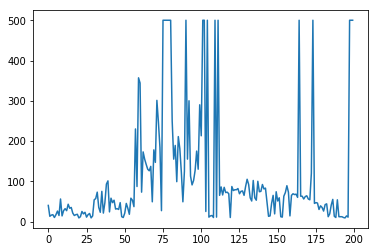

In [34]:
params = LearningParameters(env, episodes_count=200)
params.max_frame_in_episode = min(params.max_frame_in_episode, 10000)
params.epsilon_min = 0.05

# agent = PolicyGradientAgent(params)

agent = DqnAgent(params)

# agent = ActionAsInputAgent(params)

if 'session' in locals():
    session.close()
config = tf.ConfigProto(device_count = {'GPU': 0})
session = tf.Session(config=config)
session.run(agent.model['init'])

agent, rewards = train_discounted_rewards(env, agent, params, normalize_rewards=True)
# agent, rewards = train_reward_is_time(env, agent, params)
# agent, rewards = train(env, agent, params)
plt.plot(rewards)

In [ ]:
# Continue learning
params.episodes_count = 10000
agent, rewards = train_discounted_rewards(env, agent, params, normalize_rewards=True)
plt.plot(rewards)

In [20]:
evaluate(env, agent, params, 500)

Total reward: 9.0


In [ ]:
show(env, agent, params, 500, width=19, height=16, greedy=True)

In [ ]:
# Save rewards/model
pd.DataFrame(rewards).to_csv('models/rewards_40K_50K.csv', header=None)
saver = tf.train.Saver()
saver.save(session, 'models/Pong PolicyGradient', global_step=50000)